In [1]:
import pandas as pd
from pathlib import Path

data = "/Users/joryibrahim/Desktop/dataset/scan_rotated/images"

paths = [path.parts[-2:] for path in
         Path(data).rglob('*.*')]                             #writing purpose ('*.*') so that all image formats can be retrieved
df = pd.DataFrame(data=paths, columns=['Class','Images'])     #create column names for dataframe
df = df.sort_values('Class',ascending=True)                   #sort class name
df.reset_index(drop=True, inplace=True)                       #sort index of each row
df       

,Class,Images
0,alb_id,46.jpg
1,alb_id,29.jpg
2,alb_id,15.jpg
3,alb_id,01.jpg
4,alb_id,17.jpg
...,...,...
996,svk_id,57.jpg
997,svk_id,43.jpg
998,svk_id,55.jpg
999,svk_id,69.jpg


In [2]:
print('Count the number of image datasets')
print("Image Count : {}".format(len(df.Images)))
print("Class Count : {} \n".format(len(df['Class'].value_counts())))
print('Count the number of images in each class')
print(df['Class'].value_counts())

Count the number of image datasets
Image Count : 1001
Class Count : 11 

Count the number of images in each class
Class
alb_id                  100
aze_passport            100
esp_id                  100
est_id                  100
fin_id                  100
grc_passport            100
lva_passport            100
rus_internalpassport    100
srb_passport            100
svk_id                  100
images                    1
Name: count, dtype: int64


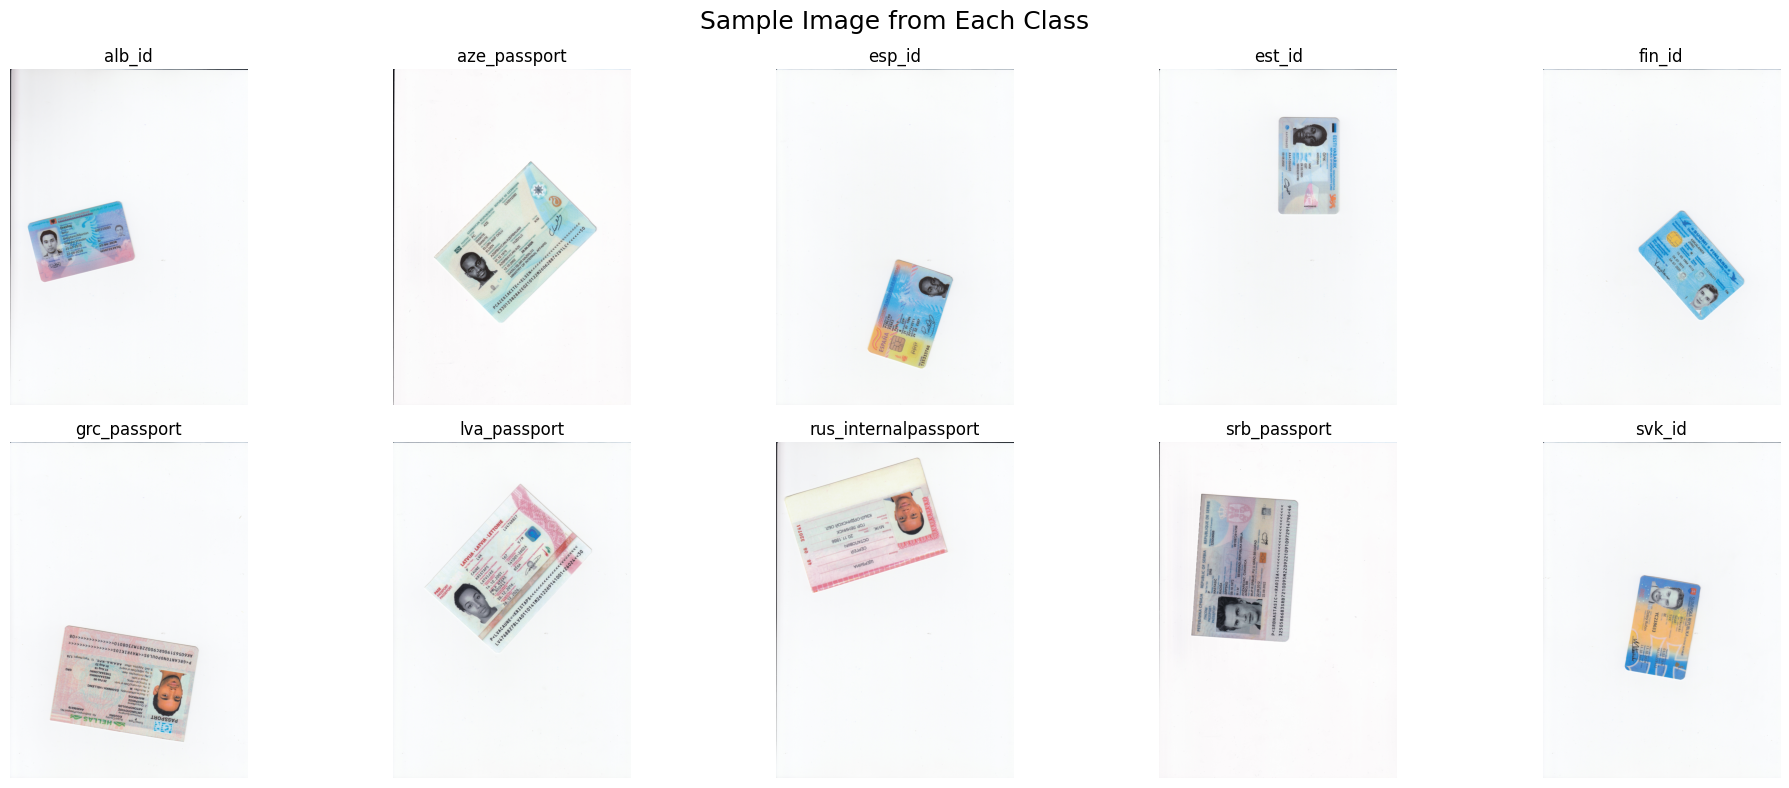

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
import os

rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))

for ax, (label, path) in zip(axes.flat, directories.items()):
    sample_img = None
    for f in os.listdir(path):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            sample_img = os.path.join(path, f)
            break
    if sample_img:
        img = Image.open(sample_img)
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')

plt.suptitle("Sample Image from Each Class", fontsize=18)
plt.tight_layout()
plt.show()

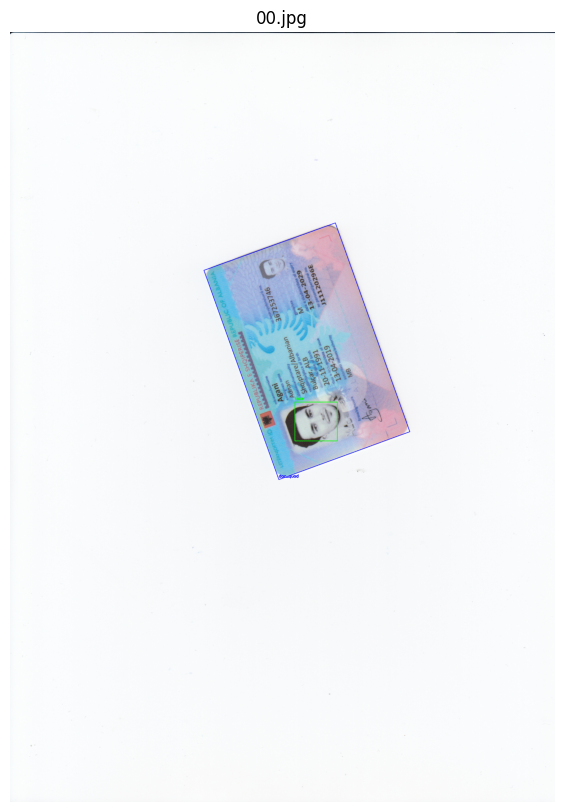

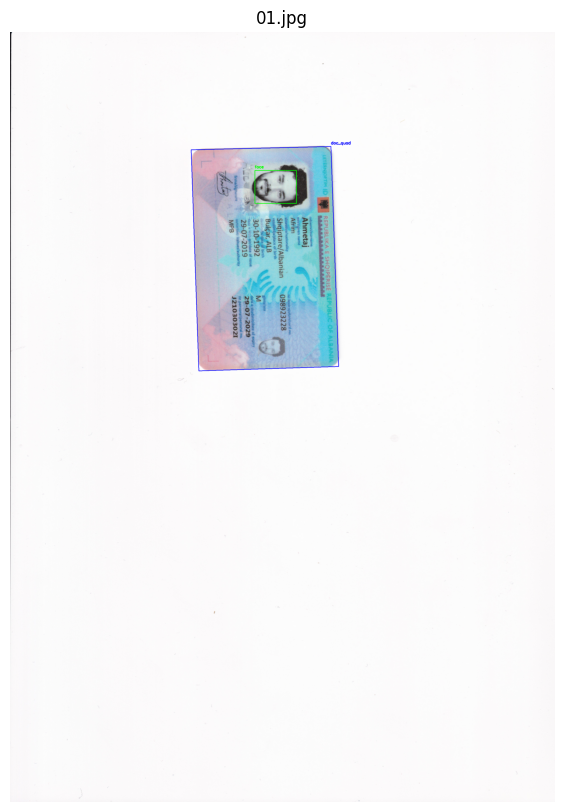

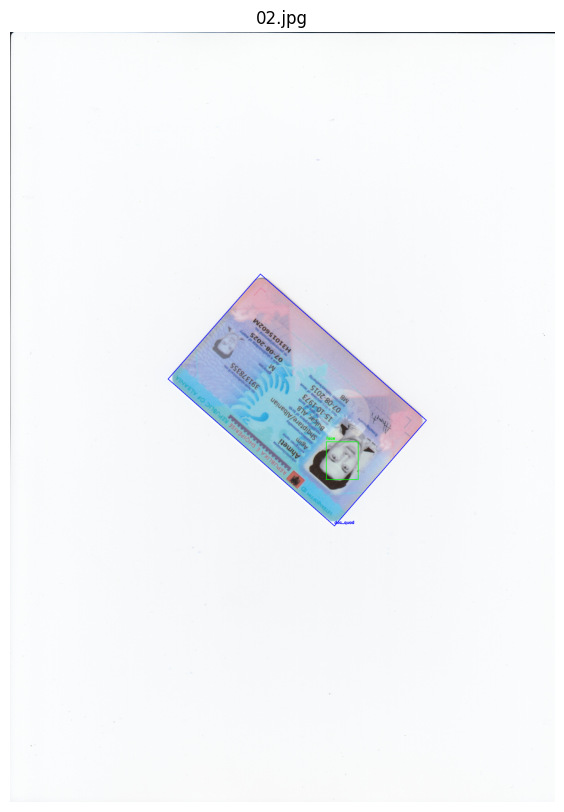

In [5]:
import json
import os
import matplotlib.pyplot as plt
import cv2

#. Draw Annotations on Images 

annotation_path = '/Users/joryibrahim/Desktop/dataset/scan_rotated/annotations/alb_id.json'
image_dir = '/Users/joryibrahim/Desktop/dataset/scan_rotated/images/alb_id'

# Load VIA annotation file
with open(annotation_path, 'r') as f:
    data = json.load(f)

metadata = data['_via_img_metadata']

def draw_annotations(image_name, info):
    img_path = os.path.join(image_dir, info['filename'])
    img = cv2.imread(img_path)
    if img is None:
        print(f"⚠️ Could not read: {img_path}")
        return

    for region in info['regions']:
        shape = region['shape_attributes']
        label = region['region_attributes'].get('field_name', 'unknown')

        if shape['name'] == 'rect':
            x, y = shape['x'], shape['y']
            w, h = shape['width'], shape['height']
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(img, label, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        elif shape['name'] == 'polygon':
            pts = list(zip(shape['all_points_x'], shape['all_points_y']))
            pts = np.array(pts, np.int32).reshape((-1, 1, 2))
            cv2.polylines(img, [pts], isClosed=True, color=(255, 0, 0), thickness=2)
            x, y = pts[0][0]
            cv2.putText(img, label, (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Display
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(info['filename'])
    plt.axis('off')
    plt.show()

# Draw first 3 annotated images
for i, (img_key, info) in enumerate(metadata.items()):
    if i == 3: break
    draw_annotations(img_key, info)

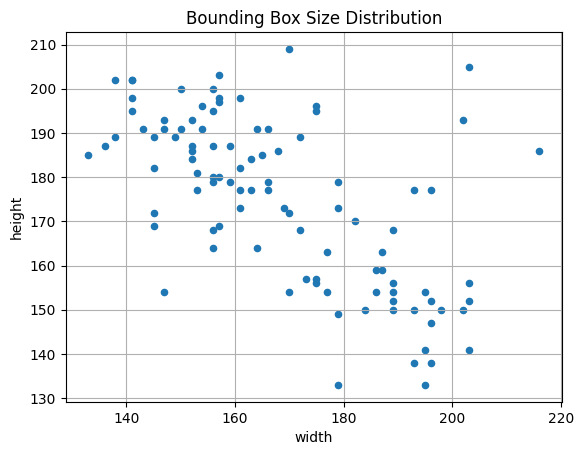

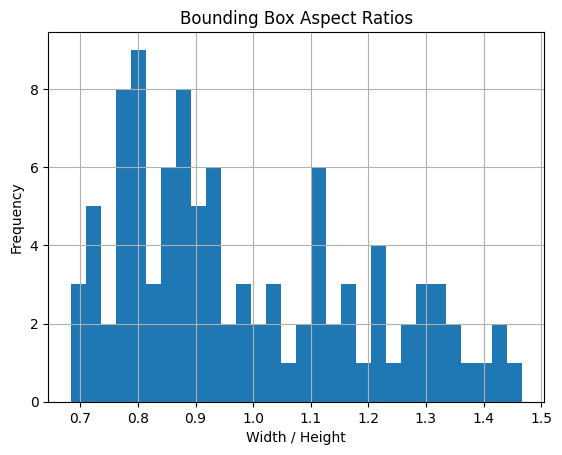

In [7]:
#Bounding Box Size & Aspect Ratio Distribution


import pandas as pd

boxes = []

for info in metadata.values():
    for region in info['regions']:
        if region['shape_attributes']['name'] == 'rect':
            shape = region['shape_attributes']
            boxes.append((shape['width'], shape['height']))

df = pd.DataFrame(boxes, columns=['width', 'height'])
df['aspect_ratio'] = df['width'] / df['height']

# Scatter plot of box sizes
df.plot.scatter(x='width', y='height', title='Bounding Box Size Distribution')
plt.grid(True)
plt.show()

# Histogram of aspect ratios
df['aspect_ratio'].plot.hist(bins=30, title='Bounding Box Aspect Ratios')
plt.xlabel("Width / Height")
plt.grid(True)
plt.show()

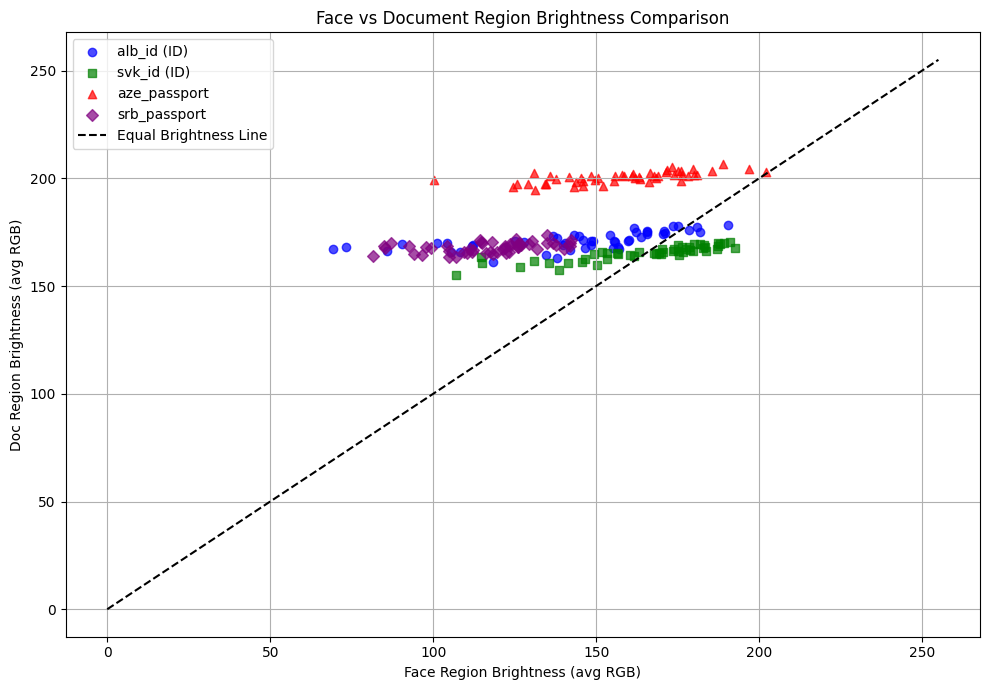

In [33]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

def extract_region_color(img, shape):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)

    if shape['name'] == 'rect':
        x, y, w, h = shape['x'], shape['y'], shape['width'], shape['height']
        mask[y:y+h, x:x+w] = 1
    elif shape['name'] == 'polygon':
        pts = np.array(list(zip(shape['all_points_x'], shape['all_points_y'])), np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.fillPoly(mask, [pts], 1)

    region_pixels = img[mask == 1]
    if region_pixels.size == 0:
        return None
    return np.mean(region_pixels, axis=0)  # BGR

def process_dataset(annotation_path, image_dir, max_images=50):
    with open(annotation_path, 'r') as f:
        data = json.load(f)
    metadata = data['_via_img_metadata']

    face_colors = []
    doc_colors = []

    for i, (img_key, info) in enumerate(metadata.items()):
        if i == max_images:
            break

        img_path = os.path.join(image_dir, info['filename'])
        img = cv2.imread(img_path)
        if img is None:
            continue

        face_color = None
        doc_color = None

        for region in info['regions']:
            label = region['region_attributes'].get('field_name', '')
            shape = region['shape_attributes']

            avg_color = extract_region_color(img, shape)
            if avg_color is None:
                continue

            if label == 'face':
                face_color = avg_color
            elif label == 'doc_quad':
                doc_color = avg_color

        if face_color is not None and doc_color is not None:
            face_colors.append(face_color)
            doc_colors.append(doc_color)

    return np.array(face_colors), np.array(doc_colors)

datasets = {
    'alb_id (ID)': {
        'annotations': '/Users/joryibrahim/Desktop/dataset/scan_rotated/annotations/alb_id.json',
        'images': '/Users/joryibrahim/Desktop/dataset/scan_rotated/images/alb_id'
    },
    'svk_id (ID)': {
        'annotations': '/Users/joryibrahim/Desktop/dataset/scan_rotated/annotations/svk_id.json',
        'images': '/Users/joryibrahim/Desktop/dataset/scan_rotated/images/svk_id'
    },
    'aze_passport': {
        'annotations': '/Users/joryibrahim/Desktop/dataset/scan_rotated/annotations/aze_passport.json',
        'images': '/Users/joryibrahim/Desktop/dataset/scan_rotated/images/aze_passport'
    },
    'srb_passport': {
        'annotations': '/Users/joryibrahim/Desktop/dataset/scan_rotated/annotations/srb_passport.json',
        'images': '/Users/joryibrahim/Desktop/dataset/scan_rotated/images/srb_passport'
    }
}

plt.figure(figsize=(10, 7))
markers = ['o', 's', '^', 'D']
colors = ['blue', 'green', 'red', 'purple']

for i, (name, paths) in enumerate(datasets.items()):
    face_colors, doc_colors = process_dataset(paths['annotations'], paths['images'])

    # Convert BGR to brightness (mean of RGB channels)
    face_brightness = face_colors[:, ::-1].mean(axis=1)  # Reverse BGR->RGB, then mean
    doc_brightness = doc_colors[:, ::-1].mean(axis=1)

    plt.scatter(face_brightness, doc_brightness,
                label=name, marker=markers[i], color=colors[i], alpha=0.7)

plt.plot([0, 255], [0, 255], 'k--', label='Equal Brightness Line')
plt.xlabel('Face Region Brightness (avg RGB)')
plt.ylabel('Doc Region Brightness (avg RGB)')
plt.title('Face vs Document Region Brightness Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


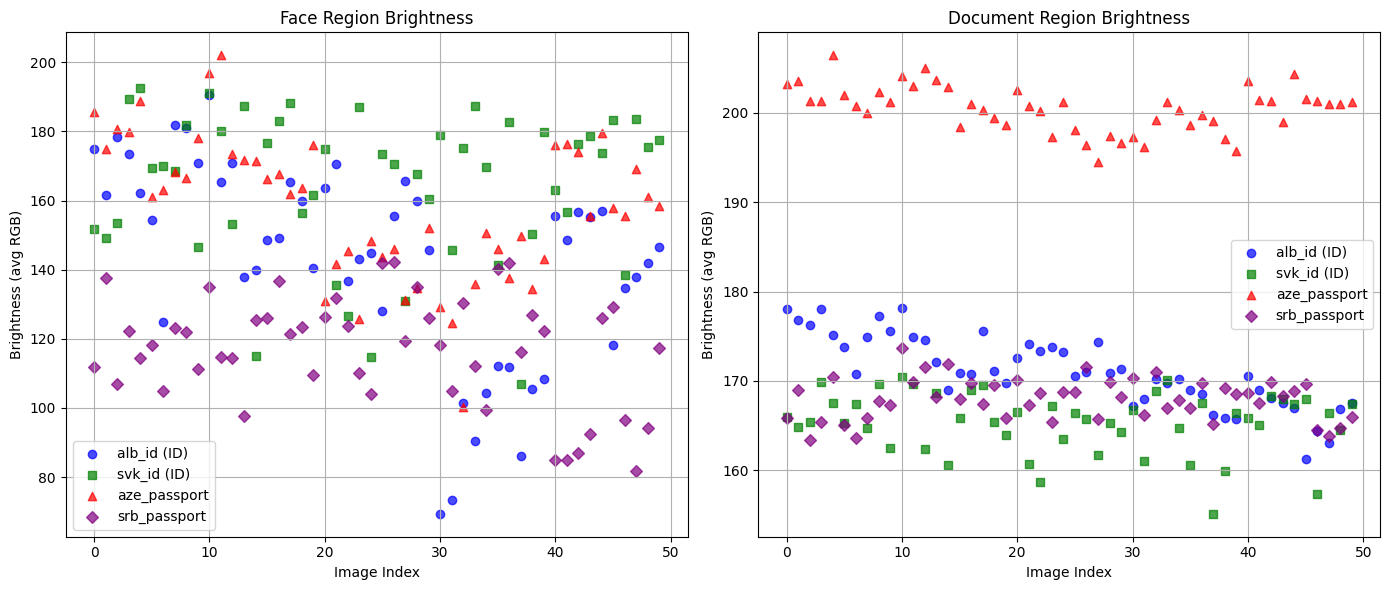

In [34]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

def extract_region_color(img, shape):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)

    if shape['name'] == 'rect':
        x, y, w, h = shape['x'], shape['y'], shape['width'], shape['height']
        mask[y:y+h, x:x+w] = 1
    elif shape['name'] == 'polygon':
        pts = np.array(list(zip(shape['all_points_x'], shape['all_points_y'])), np.int32)
        pts = pts.reshape((-1, 1, 2))
        cv2.fillPoly(mask, [pts], 1)

    region_pixels = img[mask == 1]
    if region_pixels.size == 0:
        return None
    return np.mean(region_pixels, axis=0)  # BGR

def process_dataset(annotation_path, image_dir, max_images=50):
    with open(annotation_path, 'r') as f:
        data = json.load(f)
    metadata = data['_via_img_metadata']

    face_colors = []
    doc_colors = []

    for i, (img_key, info) in enumerate(metadata.items()):
        if i == max_images:
            break

        img_path = os.path.join(image_dir, info['filename'])
        img = cv2.imread(img_path)
        if img is None:
            continue

        face_color = None
        doc_color = None

        for region in info['regions']:
            label = region['region_attributes'].get('field_name', '')
            shape = region['shape_attributes']

            avg_color = extract_region_color(img, shape)
            if avg_color is None:
                continue

            if label == 'face':
                face_color = avg_color
            elif label == 'doc_quad':
                doc_color = avg_color

        if face_color is not None:
            face_colors.append(face_color)
        if doc_color is not None:
            doc_colors.append(doc_color)

    return np.array(face_colors), np.array(doc_colors)

datasets = {
    'alb_id (ID)': {
        'annotations': '/Users/joryibrahim/Desktop/dataset/scan_rotated/annotations/alb_id.json',
        'images': '/Users/joryibrahim/Desktop/dataset/scan_rotated/images/alb_id'
    },
    'svk_id (ID)': {
        'annotations': '/Users/joryibrahim/Desktop/dataset/scan_rotated/annotations/svk_id.json',
        'images': '/Users/joryibrahim/Desktop/dataset/scan_rotated/images/svk_id'
    },
    'aze_passport': {
        'annotations': '/Users/joryibrahim/Desktop/dataset/scan_rotated/annotations/aze_passport.json',
        'images': '/Users/joryibrahim/Desktop/dataset/scan_rotated/images/aze_passport'
    },
    'srb_passport': {
        'annotations': '/Users/joryibrahim/Desktop/dataset/scan_rotated/annotations/srb_passport.json',
        'images': '/Users/joryibrahim/Desktop/dataset/scan_rotated/images/srb_passport'
    }
}

plt.figure(figsize=(14, 6))
markers = ['o', 's', '^', 'D']
colors = ['blue', 'green', 'red', 'purple']

# Plot 1: Face brightness scatter (just index vs brightness)
plt.subplot(1, 2, 1)
for i, (name, paths) in enumerate(datasets.items()):
    face_colors, _ = process_dataset(paths['annotations'], paths['images'])
    if len(face_colors) == 0:
        continue

    face_brightness = face_colors[:, ::-1].mean(axis=1)  # Convert BGR->RGB and mean brightness
    plt.scatter(range(len(face_brightness)), face_brightness,
                label=name, marker=markers[i], color=colors[i], alpha=0.7)
plt.title("Face Region Brightness")
plt.xlabel("Image Index")
plt.ylabel("Brightness (avg RGB)")
plt.legend()
plt.grid(True)

# Plot 2: Document brightness scatter (index vs brightness)
plt.subplot(1, 2, 2)
for i, (name, paths) in enumerate(datasets.items()):
    _, doc_colors = process_dataset(paths['annotations'], paths['images'])
    if len(doc_colors) == 0:
        continue

    doc_brightness = doc_colors[:, ::-1].mean(axis=1)
    plt.scatter(range(len(doc_brightness)), doc_brightness,
                label=name, marker=markers[i], color=colors[i], alpha=0.7)
plt.title("Document Region Brightness")
plt.xlabel("Image Index")
plt.ylabel("Brightness (avg RGB)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
